In [141]:
from pathlib import Path
import numpy as np
import pandas as pd
import wfdb
import matplotlib.pyplot as plt
import scipy.signal as signal
import neurokit2 as nk

base_path = r"D:\Extra datasets\brno-university-of-technology-ecg-quality-database-but-qdb-1.0.0\100001\100001"
ecg_path = base_path + r"_ECG"


In [142]:
def ann_reader(path):
    # Load annotations
    raw = pd.read_csv(path, sep=',', engine="python", header=None)
    # Optionally set column names if you know them, e.g.:
    # raw.columns = ["start1", "end1", "val1", ..., "start4", "end4", "val4"]

    for c in raw.columns:
        raw[c] = pd.to_numeric(raw[c], errors="coerce")
        if pd.api.types.is_float_dtype(raw[c]):
            if (raw[c].dropna() % 1 == 0).all():
                raw[c] = raw[c].astype('Int64')

    starts = raw.iloc[:, 9].dropna()   # 10.,11.,12. kolonne = consensus (0-baseret: 9,10,11)
    ends   = raw.iloc[:,10].dropna()
    labels   = raw.iloc[:,11].dropna()

    # Convert the loaded data
    segments = []
    for start, end, label in zip(starts, ends, labels):
        if pd.isna(start) or pd.isna(end) or pd.isna(label):
            continue
        # For each segment, fill a list with the value for each index in the range [start, end]
        segments.extend([int(label)] * (int(end) - int(start) + 1))

    # # Validation of loaded annotations

    # print(labels[0])
    # print(starts[0])
    # print(ends[0])

    # print(len(segments))  # Total length of the segments list
    # print(segments[100:])  # Print the first 100 values to verify

    return segments, starts, ends, labels

In [143]:
ann, starts, ends, labels = ann_reader(base_path + r"_ANN.csv")
print(len(ann))
print(len(starts))
print(len(ends))
print(len(labels))

87087000
763
763
763


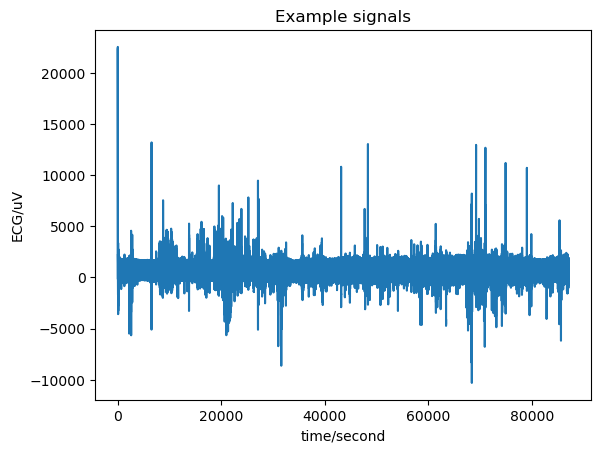

In [144]:
# load a record using the 'rdrecord' function
record = wfdb.rdrecord(ecg_path)

# plot the record to screen
wfdb.plot_wfdb(record=record, title='Example signals')

In [145]:
# Validation of loaded record, compare with raw load online: https://physionet.org/lightwave/?db=butqdb/1.0.0
# print(record.p_signal[:20] if record.p_signal is not None else record.d_signal[:20])
fs = record.fs  # Sampling frequency
print(f"Sampling frequency: {fs} Hz")

Sampling frequency: 1000 Hz


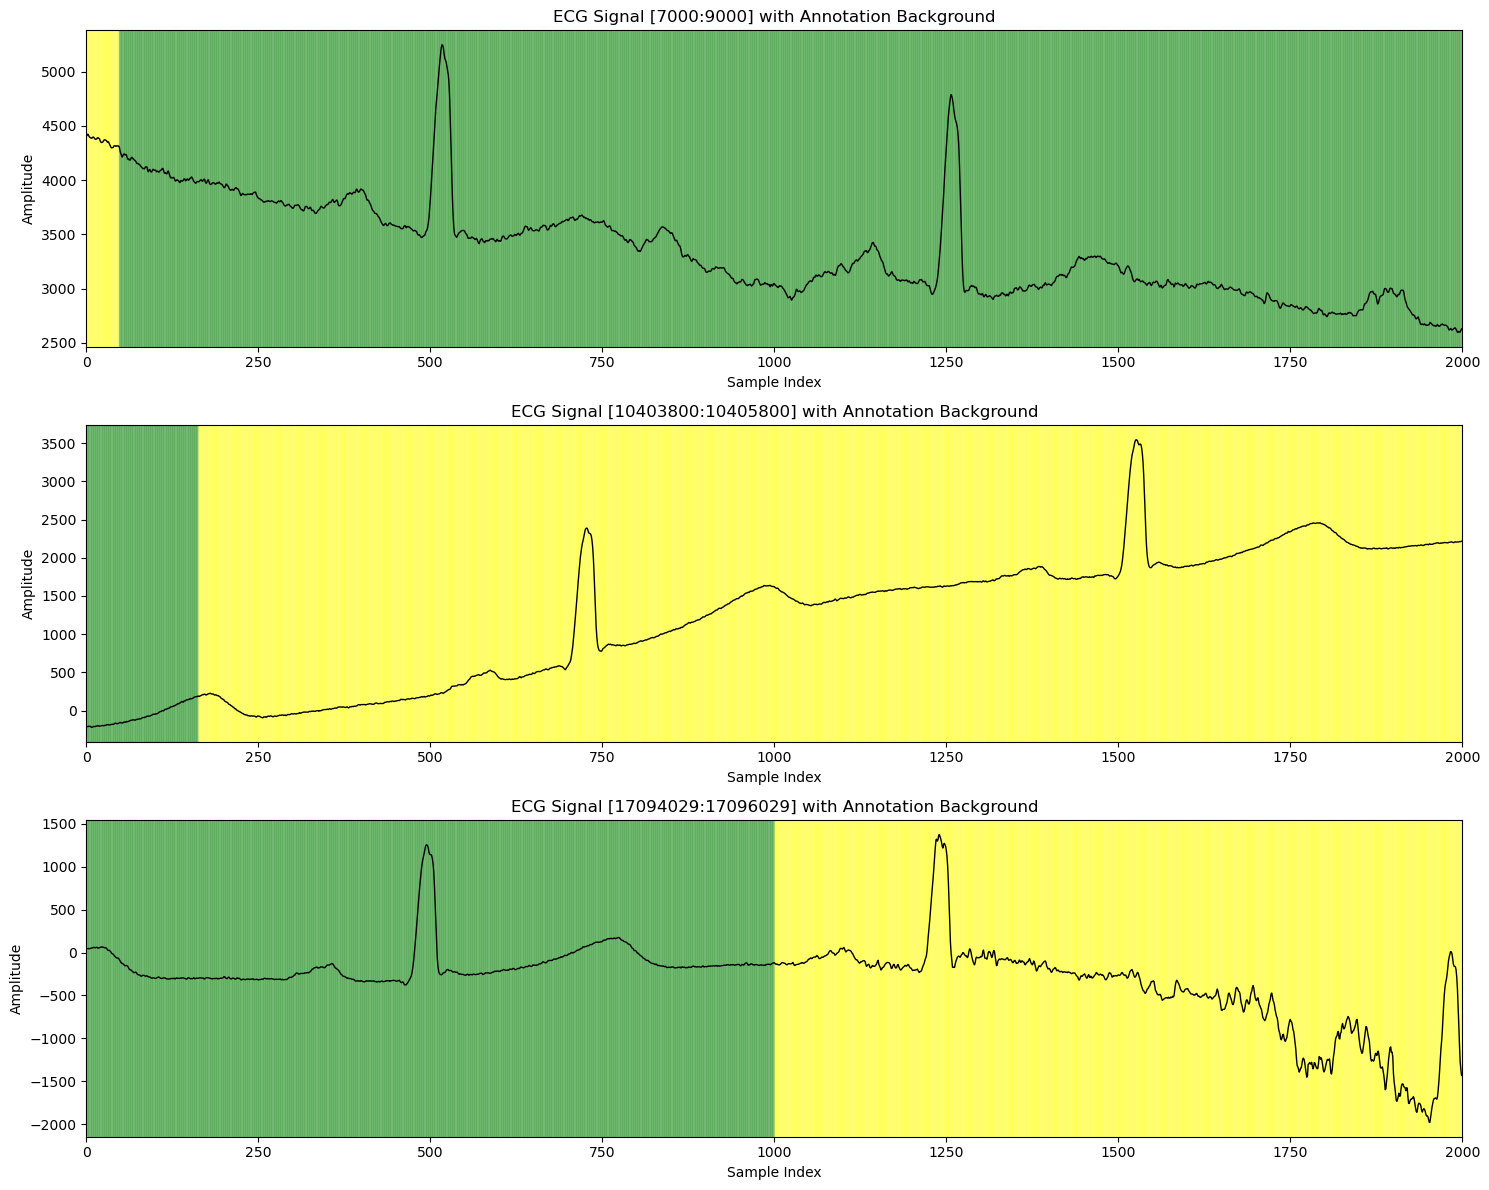

In [146]:
# Define windows to visualize (start, end) tuples
windows = [
    (7000, 9000),  # Example: 2000 samples, adjust as needed
    (10403800, 10405800),
    (17094029, 17096029)
]
colors = {
    1: 'green',   # Good quality
    2: 'yellow',  # Medium quality
    3: 'red'      # Poor quality
}

fig, axes = plt.subplots(len(windows), 1, figsize=(15, 4 * len(windows)), sharex=False)

for idx, (start, end) in enumerate(windows):
    sig = record.p_signal[start:end, 0] if record.p_signal is not None else record.d_signal[start:end, 0]
    ann_window = ann[start:end]
    ax = axes[idx] if len(windows) > 1 else axes

    ax.plot(sig, color='black', linewidth=1)
    for i in range(len(ann_window)):
        ax.axvspan(i, i+1, color=colors.get(ann_window[i], 'gray'), alpha=0.2)
    ax.set_title(f"ECG Signal [{start}:{end}] with Annotation Background")
    ax.set_xlabel("Sample Index")
    ax.set_ylabel("Amplitude")
    ax.set_xlim(0, len(sig))

plt.tight_layout()
plt.show()


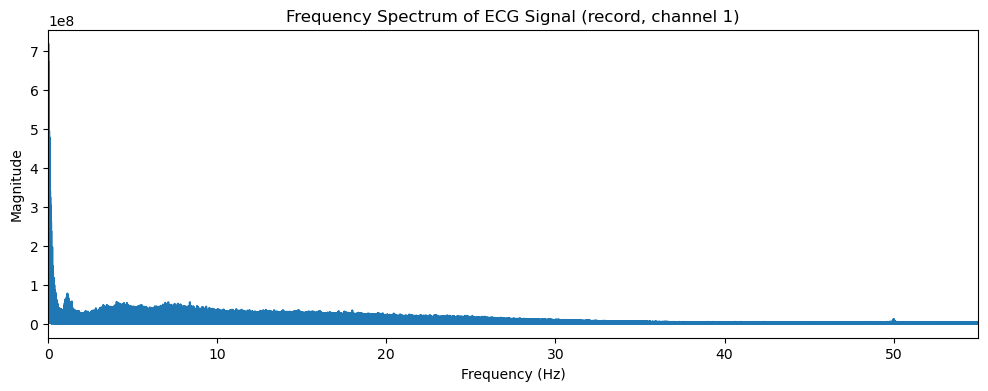

In [147]:
import matplotlib.pyplot as plt

# Frequency analysis using FFT on the signal in 'record'
raw_signal = record.p_signal if record.p_signal is not None else record.d_signal.astype(float)
fs = float(record.fs)
N = raw_signal.shape[0]

# If multi-channel, select first channel for example
sig1 = raw_signal[:, 0] if raw_signal.ndim > 1 else raw_signal

fft_raw = np.fft.fft(sig1)
freqs = np.fft.fftfreq(N, d=1/fs)
plt.figure(figsize=(12, 4))
plt.plot(freqs[:N//2], np.abs(fft_raw)[:N//2])
plt.title("Frequency Spectrum of ECG Signal (record, channel 1)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.xlim(0, 55)
plt.show()

In [148]:
b, a = signal.butter(5, 0.5, btype='highpass', fs=fs)
filtered_signal = signal.filtfilt(b, a, raw_signal[:, 0] if raw_signal.ndim > 1 else raw_signal)

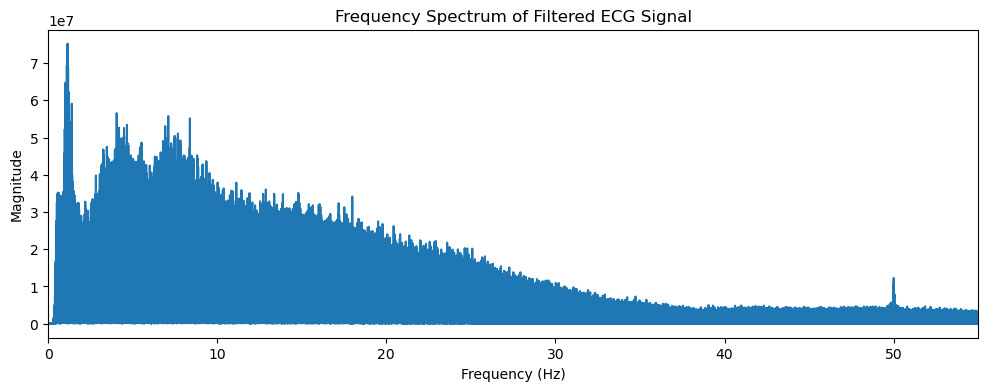

In [149]:
fft_filtered = np.fft.fft(filtered_signal)
freqs_filtered = np.fft.fftfreq(len(filtered_signal), d=1/fs)

plt.figure(figsize=(12, 4))
plt.plot(freqs_filtered[:len(filtered_signal)//2], np.abs(fft_filtered)[:len(filtered_signal)//2])
plt.title("Frequency Spectrum of Filtered ECG Signal")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.xlim(0, 55)
plt.show()

In [150]:


# Setup segments for futhere analysis
segments = []
for i in range(len(starts)-1):
    if pd.isna(starts[i]) or pd.isna(ends[i]) or pd.isna(ann[i]):
        continue
    segments.append((starts[i], ends[i]))
    # print(i)

print(f"Total segments: {len(segments)}")

# # Process each segment with ecg_quality
# quality_results = []
# for seg_start, seg_end, seg_val in segments:
#     # # Limit segment length for practical computation (e.g., max 10000 samples)
#     # if seg_end - seg_start > 10000:
#     #     seg_end = seg_start + 10000
#     segment_signal = raw_signal[seg_start:seg_end, 0] if raw_signal.ndim > 1 else raw_signal[seg_start:seg_end]
#     quality = nk.ecg_quality(segment_signal, sampling_rate=fs, method='averageQRS')
#     quality_results.append({'start': seg_start, 'end': seg_end, 'ann_val': seg_val, 'quality': quality})

Total segments: 762


In [151]:
# print(segments[0][1])



# for seg in segments:
#     nk.ecg_quality(raw_signal[seg[0]:seg[1], 0] if raw_signal.ndim > 1 else raw_signal[seg[0]:seg[1]], sampling_rate=fs, method='averageQRS')

In [152]:
import neurokit2 as nk
import numpy as np
import pandas as pd

def sqi_averageQRS(ecg, fs):
    ecg_clean = nk.ecg_clean(ecg, sampling_rate=fs, method="neurokit")
    _, info = nk.ecg_peaks(ecg_clean, sampling_rate=fs)
    q = nk.ecg_quality(ecg_clean, rpeaks=info["ECG_R_Peaks"], sampling_rate=fs, method="averageQRS")
    return q  # pr. beat; aggreger i vinduer

def sqi_zhao2018(ecg, fs):
    ecg_clean = nk.ecg_clean(ecg, sampling_rate=fs)
    _, info = nk.ecg_peaks(ecg_clean, sampling_rate=fs)
    labels = nk.ecg_quality(ecg_clean, rpeaks=info["ECG_R_Peaks"], sampling_rate=fs, method="zhao2018")
    # map {"Unacceptable":0, "Barely acceptable":1, "Excellent":2} eller til 0–1
    return labels

def sqi_hrv_rmssd(ecg, fs):
    ecg_clean = nk.ecg_clean(ecg, sampling_rate=fs)
    _, info = nk.ecg_peaks(ecg_clean, sampling_rate=fs)
    rpeaks = info["ECG_R_Peaks"]
    rr = np.diff(rpeaks) / fs  # sek
    # evt. korriger "uregelmæssige" RR her (tidsvar. tærskler) som i artiklen
    rmssd = np.sqrt(np.mean(np.diff(rr)**2))
    # implementér artiklens tærskel-logik: tælle "abnorme" RR og returnér SQI i [0,1]
    # ... din logik her ...
    return sqi_value

def sqi_morph_corr(ecg, fs, qrs_len=0.12):
    ecg_clean = nk.ecg_clean(ecg, sampling_rate=fs)
    _, info = nk.ecg_peaks(ecg_clean, sampling_rate=fs)
    epochs = nk.ecg_segment(ecg_clean, rpeaks=info["ECG_R_Peaks"], sampling_rate=fs)
    waves = [np.asarray(epochs[k]["Signal"].values) for k in epochs]  # eller brug epochs_to_df
    # z-score hvert QRS, beregn korrelation mellem konsekutive, tag gennemsnit
    corr = []
    for i in range(len(waves)-1):
        a = (waves[i] - np.mean(waves[i])) / (np.std(waves[i]) + 1e-8)
        b = (waves[i+1] - np.mean(waves[i+1])) / (np.std(waves[i+1]) + 1e-8)
        corr.append(np.corrcoef(a, b)[0,1])
    return float(np.nanmean(corr))

def classify_sqi(sqi_mean):
    if sqi_mean < 0.33:
        return "Unacceptable"
    elif sqi_mean < 0.66:
        return "Barely acceptable"
    else:
        return "Excellent"


In [153]:
# res = sqi_averageQRS(raw_signal[0:10000000],1000)

In [154]:
# print(max(res))
# print(min(res))
# print(len(res))
# print(res[7000:7100])

In [155]:
res = sqi_averageQRS(raw_signal,1000)

In [156]:
result_mean = []
result_median = []

for seg in segments:
    # print(seg[0]-1, seg[1]-1)
    
    res_mean = np.mean(res[seg[0]-1:seg[1]-1])
    result_mean.append(res_mean)
    res_median = np.median(res[seg[0]-1:seg[1]-1])
    result_median.append(res_median)

# Classify based on mean SQI
classified_mean = [classify_sqi(sqi) for sqi in result_mean]
# Classify based on median SQI
classified_median = [classify_sqi(sqi) for sqi in result_median]



In [159]:
print(len(labels))
print(len(labels_pred))

763
763


In [157]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Prepare DataFrame for evaluation
df = pd.DataFrame({
    "label_true": [classify_sqi(val) for val in labels.dropna()],
    "sqi_mean": result_mean[:len(labels.dropna())]
})
df["label_pred"] = df["sqi_mean"].apply(classify_sqi)

cm = confusion_matrix(df["label_true"], df["label_pred"], labels=["Unacceptable", "Barely acceptable", "Excellent"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Unacceptable", "Barely acceptable", "Excellent"])
disp.plot(cmap="Blues")
plt.show()

print(classification_report(df["label_true"], df["label_pred"]))


ValueError: All arrays must be of the same length

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

# --- 1) Kør én gang på HELE signalet ---
ecg_clean = nk.ecg_clean(raw_signal, sampling_rate=fs, method="neurokit")
_, info = nk.ecg_peaks(ecg_clean, sampling_rate=fs)
rpeaks_idx = info["ECG_R_Peaks"]            # beat-indeks i SAMPLES
q_beats = nk.ecg_quality(ecg_clean, rpeaks=rpeaks_idx, sampling_rate=fs, method="averageQRS")
# q_beats har samme længde som rpeaks_idx

In [ ]:
# Check and validation of parameters
print(len(segments))
print(len(labels))
print(rpeaks_idx.shape)
print(rpeaks_idx[1])

print(segments)
print(q_beats.shape)

763
763
(117206,)
854
[(1, 7047), (7048, 17209), (17210, 28694), (28695, 32653), (32654, 112474), (112475, 174872), (174873, 192330), (192331, 1163574), (1163575, 1165034), (1165035, 2197584), (2197585, 2322254), (2322255, 2331166), (2331167, 2333950), (2333951, 2353306), (2353307, 2582882), (2582883, 2778473), (2778474, 2789032), (2789033, 6493775), (6493776, 6494615), (6494616, 6504788), (6504789, 6528944), (6528945, 8103188), (8103189, 8183677), (8183678, 8207266), (8207267, 8269766), (8269767, 8285982), (8285983, 8679655), (8679656, 8736748), (8736749, 8746245), (8746246, 9369503), (9369504, 9796000), (9796001, 10032664), (10032665, 10033565), (10033566, 10296954), (10296955, 10335664), (10335665, 10403962), (10403963, 10542981), (10542982, 11468257), (11468258, 11477831), (11477832, 11644085), (11644086, 11656399), (11656400, 12844392), (12844393, 12854198), (12854199, 13742716), (13742717, 13760626), (13760627, 15836454), (15836455, 15869858), (15869859, 15993438), (15993439, 160

In [162]:
print(len(labels))
print(len(labels_pred))

763
762


In [161]:
# Get predictions for each segment
labels_pred = []
for seg in segments:
    # Find beats within the segment
    beats_in_segment = (rpeaks_idx >= seg[0]) & (rpeaks_idx <= seg[1])
    seg_q_beats = q_beats[beats_in_segment]
    if len(seg_q_beats) == 0:
        # No beats in segment, handle as needed (e.g., assign lowest quality)
        labels_pred.append(3)
        continue
    seg_sqi_mean = np.mean(seg_q_beats)
    if seg_sqi_mean < 0.33:
        labels_pred.append(3)  # Unacceptable
    elif seg_sqi_mean < 0.66:
        labels_pred.append(2)  # Barely acceptable
    else:
        labels_pred.append(1)  # Excellent

# --- 2) Evaluer resultatet ---
# Prepare DataFrame for evaluation
df = pd.DataFrame({
    "label_true": labels.dropna().astype(int).values,
    "label_pred": labels_pred
})
df["label_true_str"] = df["label_true"].map({1: "Excellent", 2: "Barely acceptable", 3: "Unacceptable"})
df["label_pred_str"] = df["label_pred"].map({1: "Excellent", 2: "Barely acceptable", 3: "Unacceptable"})
cm = confusion_matrix(df["label_true_str"], df["label_pred_str"], labels=["Unacceptable", "Barely acceptable", "Excellent"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Unacceptable", "Barely acceptable", "Excellent"])
disp.plot(cmap="Blues")
plt.show()



ValueError: All arrays must be of the same length